<a href="https://colab.research.google.com/github/R267/Pryklad_analyz_exam/blob/main/task6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
robikscube_flight_delay_dataset_20182022_path = kagglehub.dataset_download('robikscube/flight-delay-dataset-20182022')

print('Data source import complete.')


100%|██████████| 3.73G/3.73G [00:31<00:00, 127MB/s]

Extracting files...


Data source import complete.


# Дослідження авіаційних даних


Створено в прямому ефірі.
Дивіться відео тут: https://youtu.be/xs_L6z9QNYY

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

pd.set_option("display.max_columns", 500)
sns.set_palette("colorblind")  # замість стилю
sns.set_style("darkgrid")      # або стилізація через seaborn


In [4]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep parquet

ls: cannot access '../input/flight-delay-dataset-20182022/': No such file or directory


In [5]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep csv

ls: cannot access '../input/flight-delay-dataset-20182022/': No such file or directory


# Зчитування та форматування даних

In [10]:
parquet_files = glob("/content/Combined_Flights_2018.parquet")

In [11]:
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
]

dfs = []
for f in parquet_files:
    dfs.append(pd.read_parquet(f, columns=column_subset))
df = pd.concat(dfs).reset_index(drop=True)

cat_cols = ["Airline", "Origin", "Dest", "OriginStateName", "DestStateName"]
for c in cat_cols:
    df[c] = df[c].astype("category")

# Зрозуміти змінну DepDelayMinutes



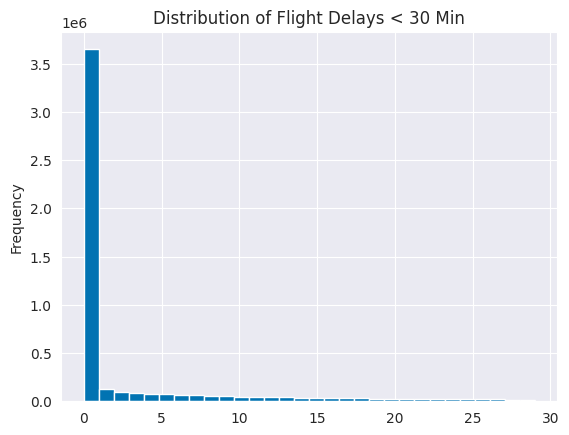

In [12]:
df.query("DepDelayMinutes < 30")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

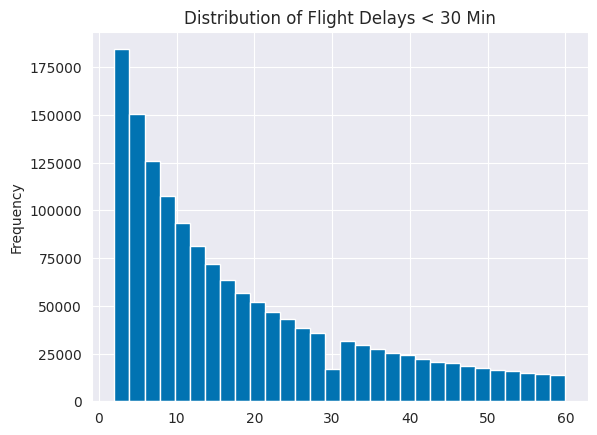

In [13]:
df.query("DepDelayMinutes > 1 and DepDelayMinutes < 61")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

# Групування затримок
Згідно з Вікіпедією https://en.wikipedia.org/wiki/Flight_cancellation_and_delay:
```
Затримки поділяються на три категорії, а саме: "вчасно або незначна затримка" (до 15 хвилин), "середня затримка" (від 15 до 45 хвилин) та "велика затримка" (понад 45 хвилин).
```

In [14]:
df["DelayGroup"] = None
df.loc[df["DepDelayMinutes"] == 0, "DelayGroup"] = "OnTime_Early"
df.loc[
    (df["DepDelayMinutes"] > 0) & (df["DepDelayMinutes"] <= 15), "DelayGroup"
] = "Small_Delay"
df.loc[
    (df["DepDelayMinutes"] > 15) & (df["DepDelayMinutes"] <= 45), "DelayGroup"
] = "Medium_Delay"
df.loc[df["DepDelayMinutes"] > 45, "DelayGroup"] = "Large_Delay"
df.loc[df["Cancelled"], "DelayGroup"] = "Cancelled"

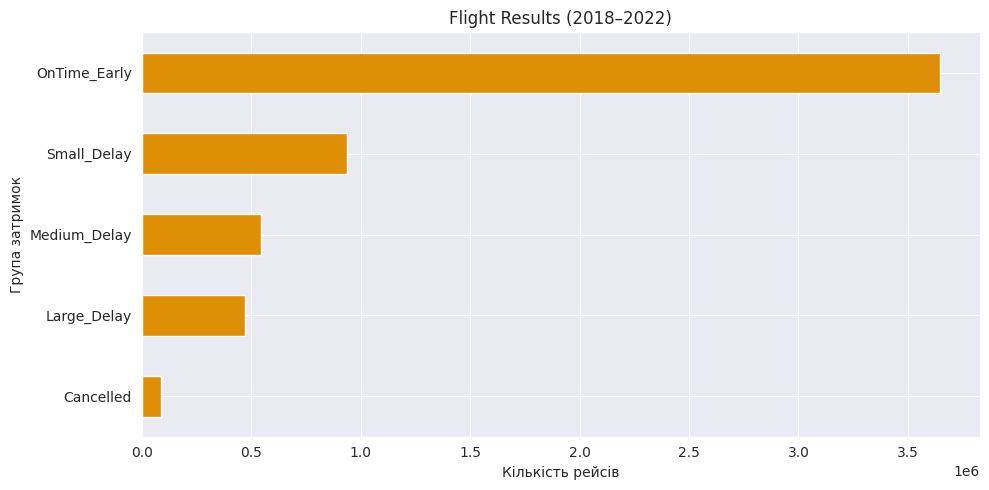

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Створення палітри
pal = sns.color_palette("colorblind")

# Побудова графіка
df["DelayGroup"].value_counts(ascending=True).plot(
    kind="barh", figsize=(10, 5), color=pal[1], title="Flight Results (2018–2022)"
)
plt.xlabel("Кількість рейсів")
plt.ylabel("Група затримок")
plt.tight_layout()
plt.show()


# Скільки рейсів на рік?

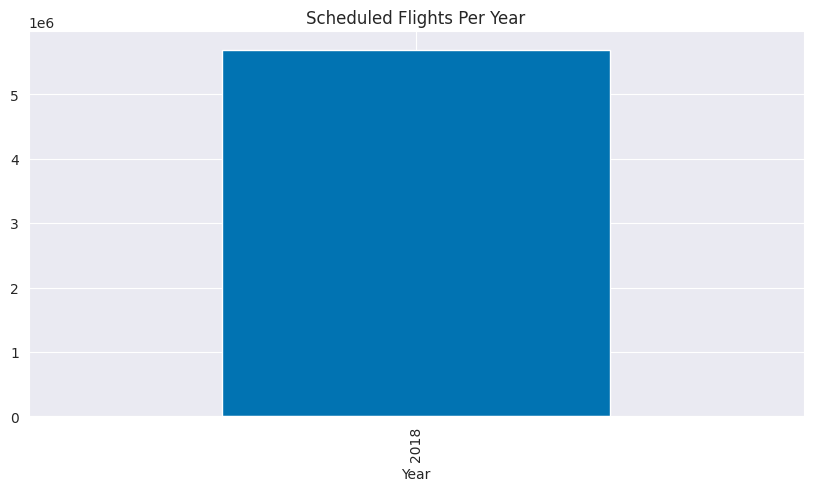

In [17]:
df["Year"] = df['FlightDate'].dt.year
df["Year"].value_counts().sort_index().plot(
    kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year"
)
plt.show()

# Який відсоток результатів рейсів за рік?

In [18]:
df["Year"] = df["FlightDate"].dt.year
df_agg = df.groupby("Year")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Greens")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.115615,16.474583,9.538448,8.317789,1.553565


# Результати за місяць



In [19]:
df["Month"] = df["FlightDate"].dt.month
df_agg = df.groupby("Month")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,65.026312,15.167608,9.050127,7.980350,2.775603
2,60.529643,18.386080,11.059473,8.104287,1.920516
3,62.037893,18.237551,10.091526,7.050489,2.582541
4,65.784553,16.446086,9.217935,7.560888,0.990538
5,60.495538,17.976883,10.683228,9.601650,1.242701
6,57.143442,19.164587,11.534382,10.802270,1.355320
7,58.509068,18.068733,11.068842,10.660912,1.692446
8,59.223289,16.496463,10.389964,11.573218,2.317066
9,70.249555,13.513191,7.620755,7.126098,1.490400


## Не враховувати 2020 рік



In [20]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("Year != 2020")
    .groupby("Month")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,65.026312,15.167608,9.050127,7.980350,2.775603
2,60.529643,18.386080,11.059473,8.104287,1.920516
3,62.037893,18.237551,10.091526,7.050489,2.582541
4,65.784553,16.446086,9.217935,7.560888,0.990538
5,60.495538,17.976883,10.683228,9.601650,1.242701
6,57.143442,19.164587,11.534382,10.802270,1.355320
7,58.509068,18.068733,11.068842,10.660912,1.692446
8,59.223289,16.496463,10.389964,11.573218,2.317066
9,70.249555,13.513191,7.620755,7.126098,1.490400


## Чому високий рівень скасувань у березні/квітні? Як це виглядає за роками для цих місяців?



In [21]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("3 <= Month <= 4")
    .groupby("Year")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Oranges", axis=0)

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.219260,17.194531,9.582907,7.347652,1.655651


# Побудувати графік за допомогою calmap

In [22]:
!pip install calmap plotly_calplot -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 35.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


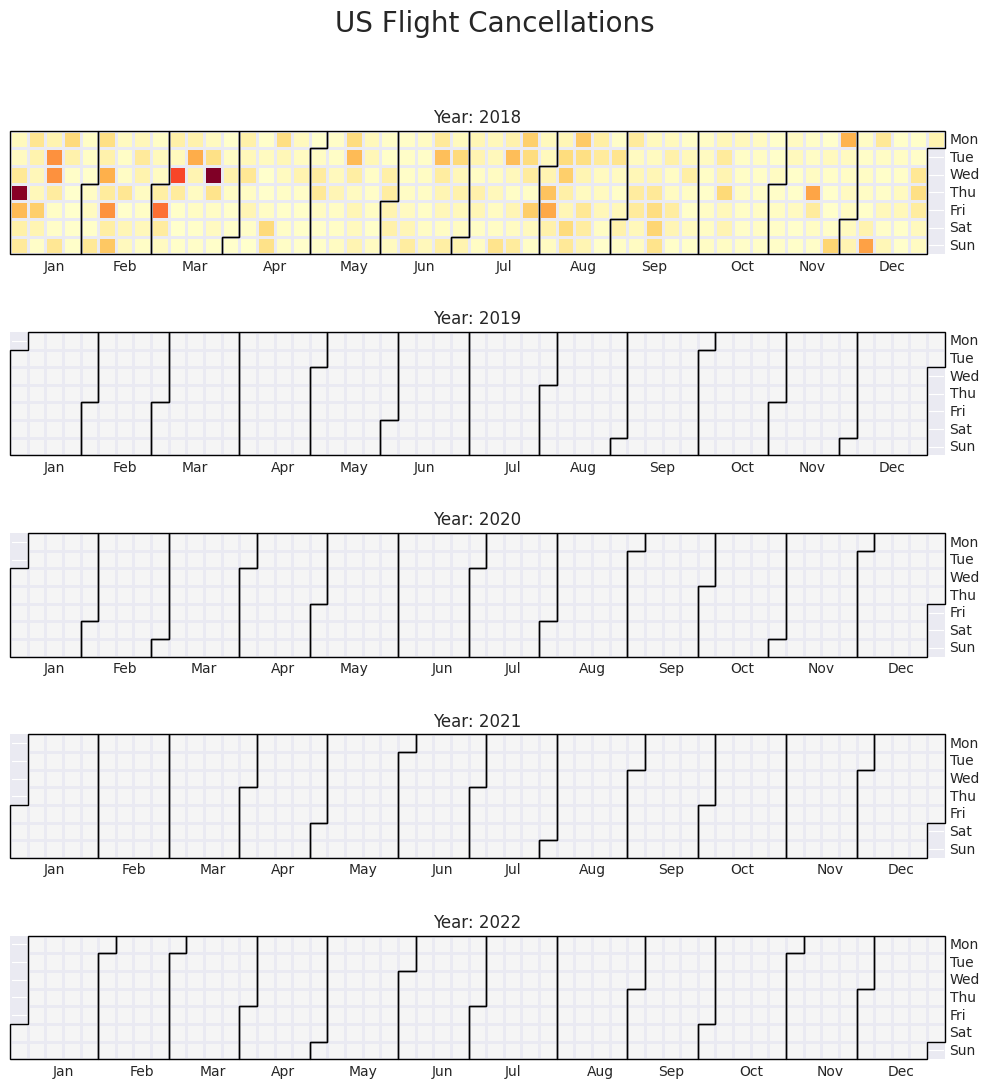

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calmap

# Переконаємося, що колонка FlightDate у форматі datetime
df["FlightDate"] = pd.to_datetime(df["FlightDate"])

# Групуємо по датах, беремо середнє значення 'Cancelled' (0 або 1)
events = df.groupby("FlightDate")["Cancelled"].mean()

# Створюємо індекс з усіма датами між мінімальною і максимальною датою
all_days = pd.date_range(start=events.index.min(), end=events.index.max())

# Реіндексуємо series, заповнюємо пропуски 0
events = events.reindex(all_days, fill_value=0)

fig, axs = plt.subplots(5, 1, figsize=(10, 12))

years = [2018, 2019, 2020, 2021, 2022]

for i, year in enumerate(years):
    # Відбираємо дані за поточний рік
    year_data = events[events.index.year == year]

    # Логарифмізуємо (додаємо 1, щоб уникнути log(0))
    year_data_log = np.log(year_data + 1)

    # Будуємо календарний графік
    calmap.yearplot(
        year_data_log,
        year=year,
        cmap="YlOrRd",
        monthly_border=True,
        ax=axs[i]
    )
    axs[i].set_title(f"Year: {year}")

fig.patch.set_facecolor("white")
fig.suptitle("US Flight Cancellations", y=0.92, fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


# Інтерактивна календарна теплова карта



In [26]:
import numpy as np
from plotly_calplot import calplot

# events — це Series, індекс — DatetimeIndex, значення — середнє по 'Cancelled'
# Переконайтесь, що індекс має назву 'FlightDate'
events.index.name = 'FlightDate'

# Перетворюємо Series у DataFrame із колонками 'FlightDate' і 'Cancelled'
df_events = events.apply(np.log).reset_index(name='Cancelled')

# Створюємо теплову карту
fig = calplot(df_events, x="FlightDate", y="Cancelled")

fig.show()


Порівняння авіакомпаній
У кого найбільше затримок?

У кого найбільше скасувань?

Хто найнадійніший? (вчасно)

Text(0.5, 0, 'Flights (100k)')

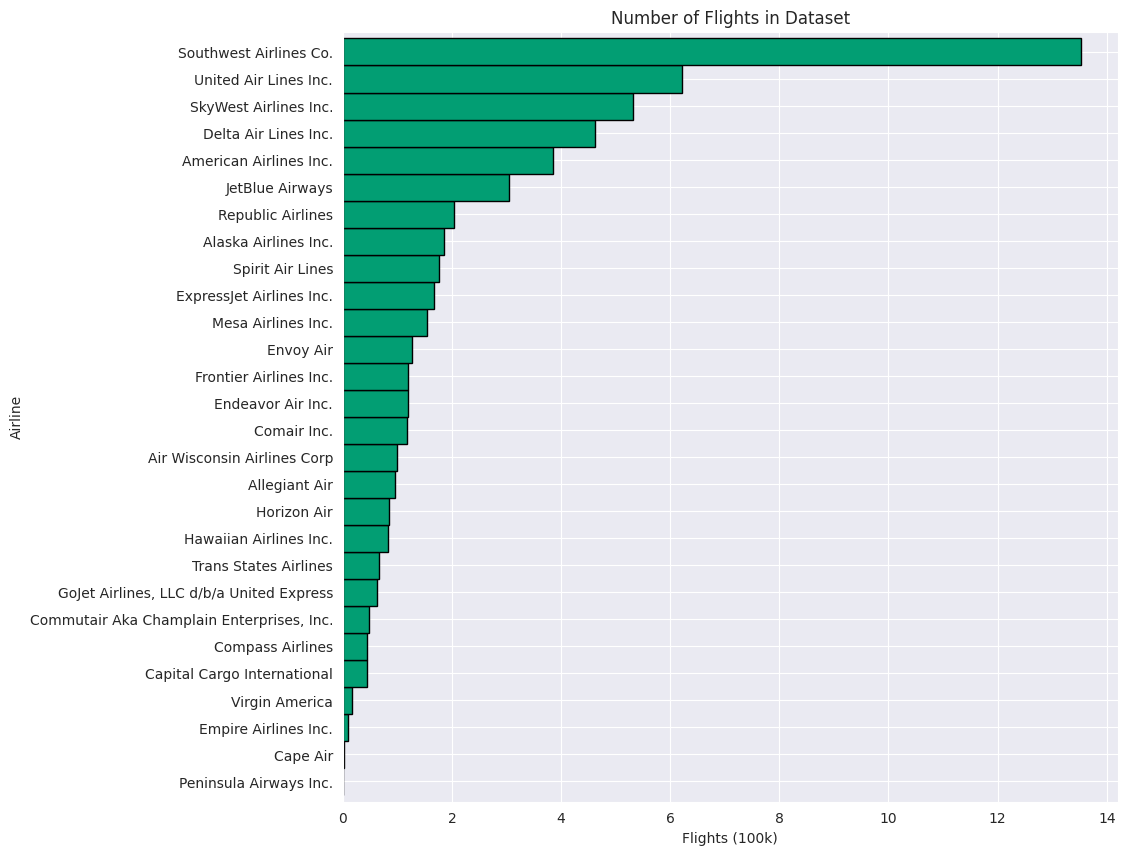

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
airlines_ordered = (df["Airline"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")

Вибірка за провідними авіакомпаніями
Мінімум 1 мільйон рейсів

In [30]:
vc = df["Airline"].value_counts().reset_index()
vc.columns = ['Airline', 'count']

top_airlines = vc[vc['count'] > 1_000_000]['Airline'].tolist()

df_top = df[df['Airline'].isin(top_airlines)].reset_index(drop=True).copy()



In [31]:
# Reset airline categories
df_top["Airline"] = df_top["Airline"].astype("str").astype("category")

<ipython-input-32-45cd8764198f>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



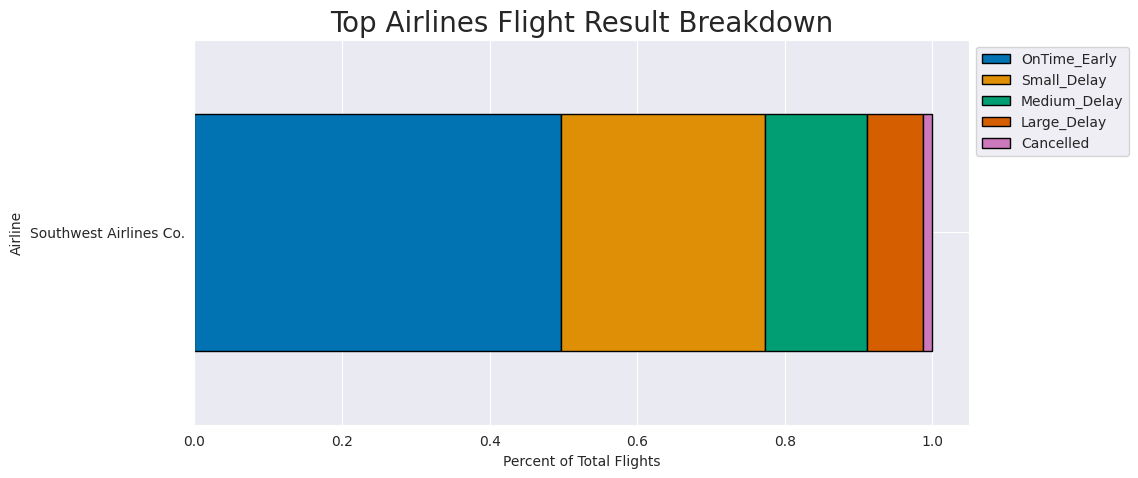

In [32]:
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top.groupby(["Airline"])["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

## Розділити за типами затримок і побудувати графік










In [33]:
delay_mapping = {
    "OnTime_Early": "Good",
    "Small_Delay": "Good",
    "Medium_Delay": "Bad",
    "Large_Delay": "Bad",
    "Cancelled": "Bad",
}

In [34]:
df_top["DelayOk"] = df_top["DelayGroup"].map(delay_mapping)

<ipython-input-35-ce4138cd97a2>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



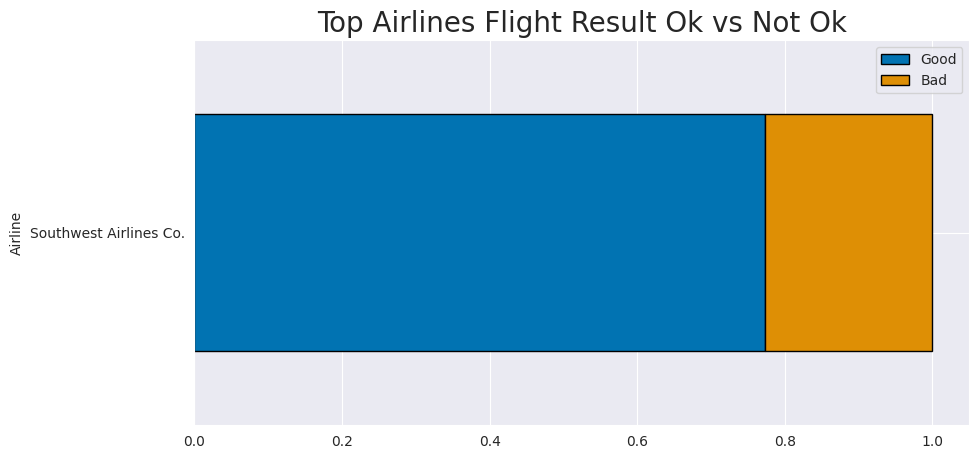

In [35]:
df_agg = (
    df_top.groupby(["Airline"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()